In [10]:
# Imports
import os
from pathlib import Path
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from seqeval.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DATA_DIR = Path("../../data/ner")

Using device: cuda


In [11]:
# Load vocabularies and mappings
with open(DATA_DIR / "word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)

with open(DATA_DIR / "pos2idx.pkl", "rb") as f:
    pos2idx = pickle.load(f)

with open(DATA_DIR / "tag2idx.pkl", "rb") as f:
    tag2idx = pickle.load(f)

# Create reverse mappings
idx2word = {v: k for k, v in word2idx.items()}
idx2pos = {v: k for k, v in pos2idx.items()}
idx2tag = {v: k for k, v in tag2idx.items()}

PAD_IDX = word2idx['<PAD>']
UNK_IDX = word2idx['<UNK>']

print(f"Vocab size: {len(word2idx)}, POS size: {len(pos2idx)}, Number of tags: {len(tag2idx)}")

Vocab size: 35179, POS size: 43, Number of tags: 18


In [12]:
# Load dataset numpy arrays
Xw_val = np.load(DATA_DIR / "Xw_val.npy")
Xp_val = np.load(DATA_DIR / "Xp_val.npy")
Yt_val = np.load(DATA_DIR / "Yt_val.npy")

print(f"Validation samples: {len(Xw_val)}")

Validation samples: 9592


In [13]:
# Native CRF Implementation
class CRF(nn.Module):
    """Native CRF implementation without external dependencies"""
    
    def __init__(self, num_tags, batch_first=True):
        super(CRF, self).__init__()
        self.num_tags = num_tags
        self.batch_first = batch_first
        
        # Transition parameters: transition[i][j] = score of transitioning from tag i to tag j
        self.transitions = nn.Parameter(torch.randn(num_tags, num_tags))
        
        # Initialize transitions (don't allow transitions to PAD)
        self.transitions.data[PAD_IDX, :] = -10000  # No transitions from PAD
        self.transitions.data[:, PAD_IDX] = -10000  # No transitions to PAD
    
    def _compute_partition_function(self, emissions, mask):
        """Compute the partition function using forward algorithm"""
        batch_size, seq_length, num_tags = emissions.size()
        
        # Initialize forward variables
        forward_var = emissions[:, 0].clone()  # (batch_size, num_tags)
        
        for i in range(1, seq_length):
            # Broadcast forward_var and transitions for batch processing
            emit_score = emissions[:, i].unsqueeze(1)  # (batch_size, 1, num_tags)
            trans_score = self.transitions.unsqueeze(0)  # (1, num_tags, num_tags)
            next_tag_var = forward_var.unsqueeze(2) + trans_score + emit_score
            
            # Use logsumexp for numerical stability
            next_tag_var = torch.logsumexp(next_tag_var, dim=1)  # (batch_size, num_tags)
            
            # Apply mask
            forward_var = torch.where(mask[:, i].unsqueeze(1), next_tag_var, forward_var)
        
        # Sum over all possible ending tags
        terminal_var = torch.logsumexp(forward_var, dim=1)  # (batch_size,)
        return terminal_var
    
    def _compute_score(self, emissions, tags, mask):
        """Compute the score of a given tag sequence"""
        batch_size, seq_length = tags.size()
        
        # Compute emission scores
        emission_scores = torch.gather(emissions, 2, tags.unsqueeze(2)).squeeze(2)
        emission_scores = emission_scores * mask.float()
        emission_scores = emission_scores.sum(dim=1)  # (batch_size,)
        
        # Compute transition scores
        transition_scores = torch.zeros(batch_size, device=emissions.device)
        
        for i in range(seq_length - 1):
            curr_tags = tags[:, i]
            next_tags = tags[:, i + 1]
            
            # Get transition scores for valid positions
            valid_mask = mask[:, i + 1]
            trans_score = self.transitions[curr_tags, next_tags]
            transition_scores += trans_score * valid_mask.float()
        
        return emission_scores + transition_scores
    
    def forward(self, emissions, tags, mask=None):
        """Compute CRF negative log likelihood"""
        if mask is None:
            mask = torch.ones_like(tags, dtype=torch.bool)
        
        # Compute partition function (normalizer)
        partition = self._compute_partition_function(emissions, mask)
        
        # Compute score of the given sequence
        sequence_score = self._compute_score(emissions, tags, mask)
        
        # Return negative log likelihood
        return (partition - sequence_score).mean()
    
    def decode(self, emissions, mask=None):
        """Viterbi decoding to find the best sequence"""
        if mask is None:
            mask = torch.ones(emissions.size()[:2], dtype=torch.bool, device=emissions.device)
        
        batch_size, seq_length, num_tags = emissions.size()
        
        # Initialize
        viterbi_vars = emissions[:, 0].clone()  # (batch_size, num_tags)
        path_scores = []
        
        # Forward pass
        for i in range(1, seq_length):
            broadcast_vars = viterbi_vars.unsqueeze(2)  # (batch_size, num_tags, 1)
            broadcast_trans = self.transitions.unsqueeze(0)  # (1, num_tags, num_tags)
            next_tag_vars = broadcast_vars + broadcast_trans
            
            # Find best previous tags
            best_tag_scores, best_tags = torch.max(next_tag_vars, dim=1)
            path_scores.append(best_tags)
            
            # Add emission scores
            best_tag_scores += emissions[:, i]
            
            # Apply mask
            viterbi_vars = torch.where(mask[:, i].unsqueeze(1), best_tag_scores, viterbi_vars)
        
        # Backward pass to find best path
        best_paths = []
        
        for batch_idx in range(batch_size):
            # Find best final tag
            seq_len = mask[batch_idx].sum().item()
            if seq_len == 0:
                best_paths.append([])
                continue
            
            _, best_last_tag = torch.max(viterbi_vars[batch_idx], dim=0)
            best_path = [best_last_tag.item()]
            
            # Backtrack
            for i in range(len(path_scores) - 1, -1, -1):
                if i + 1 < seq_len:
                    best_last_tag = path_scores[i][batch_idx][best_last_tag]
                    best_path.append(best_last_tag.item())
            
            # Reverse to get correct order
            best_path.reverse()
            
            # Pad with zeros if necessary
            while len(best_path) < seq_len:
                best_path.append(0)
            
            best_paths.append(best_path[:seq_len])
        
        return best_paths

In [14]:
# BiLSTM-CRF Model
class BiLSTM_CRF_Enhanced(nn.Module):
    def __init__(self, config):
        super(BiLSTM_CRF_Enhanced, self).__init__()
        self.config = config
        self.pad_idx = PAD_IDX
        
        # Word embeddings
        self.word_embedding = nn.Embedding(
            config['vocab_size'], config['word_embed_dim'], padding_idx=self.pad_idx
        )
        
        # POS embeddings
        self.pos_embedding = nn.Embedding(
            config['pos_vocab_size'], config['pos_embed_dim']
        )
        
        # Character-level CNN for better OOV handling
        self.char_embed_dim = 30
        self.char_cnn = self._build_char_cnn()
        
        # BiLSTM layers
        total_embed_dim = (config['word_embed_dim'] + 
                          config['pos_embed_dim'] + 
                          config['char_embed_dim'])
        
        self.lstm = nn.LSTM(
            input_size=total_embed_dim,
            hidden_size=config['hidden_dim'],
            num_layers=config['num_layers'],
            batch_first=True,
            bidirectional=True,
            dropout=config['dropout'] if config['num_layers'] > 1 else 0
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(config['hidden_dim'] * 2)
        
        # Dropout
        self.dropout = nn.Dropout(config['dropout'])
        
        # Linear layer for emissions
        self.hidden2tag = nn.Linear(
            config['hidden_dim'] * 2, config['tag_vocab_size']
        )
        
        # CRF layer
        self.crf = CRF(config['tag_vocab_size'], batch_first=True)
        
        # Initialize weights
        self._init_weights()
    
    def _build_char_cnn(self):
        """Build char CNN to match the actual checkpoint - SIMPLIFIED VERSION"""
        return nn.Sequential(
            nn.Conv1d(30, 50, kernel_size=3, padding=1),
            nn.AdaptiveMaxPool1d(1),
            nn.Dropout(0.25)
        )
    
    def _get_char_features(self, words):
        """Extract character-level features"""
        batch_size, seq_len = words.size()
        char_features = torch.zeros(batch_size, seq_len, self.config['char_embed_dim'], 
                                   device=words.device)
        
        # Simple character features
        for i in range(batch_size):
            for j in range(seq_len):
                word_idx = words[i, j].item()
                if word_idx != self.pad_idx:
                    word = idx2word.get(word_idx, '')
                    # Simple character encoding (first few characters)
                    for k, char in enumerate(word[:self.config['char_embed_dim']]):
                        char_features[i, j, k] = ord(char) % 128
        
        return char_features
    
    def _init_weights(self):
        """Initialize model weights"""
        # Initialize embeddings
        nn.init.uniform_(self.word_embedding.weight, -0.1, 0.1)
        nn.init.uniform_(self.pos_embedding.weight, -0.1, 0.1)
        
        # Initialize LSTM
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        # Initialize linear layer
        nn.init.xavier_uniform_(self.hidden2tag.weight)
        nn.init.constant_(self.hidden2tag.bias, 0)
    
    def forward(self, words, pos, tags=None):
        batch_size, seq_len = words.size()
        
        # Create mask
        mask = (words != self.pad_idx)
        
        # Get embeddings
        word_embeds = self.word_embedding(words)
        pos_embeds = self.pos_embedding(pos)
        char_features = self._get_char_features(words)
        
        # Concatenate embeddings
        embeds = torch.cat([word_embeds, pos_embeds, char_features], dim=2)
        embeds = self.dropout(embeds)
        
        # BiLSTM
        lstm_out, _ = self.lstm(embeds)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        
        # Get emission scores
        emissions = self.hidden2tag(lstm_out)
        
        if tags is not None:
            # Training mode: return CRF loss
            loss = self.crf(emissions, tags, mask)
            return loss
        else:
            # Inference mode: return best sequence
            best_paths = self.crf.decode(emissions, mask)
            return best_paths

In [15]:
# Configuration
CONFIG = {
    'vocab_size': len(word2idx),
    'pos_vocab_size': len(pos2idx),
    'tag_vocab_size': len(tag2idx),
    'word_embed_dim': 150,
    'pos_embed_dim': 25,
    'char_embed_dim': 50,
    'hidden_dim': 300,
    'num_layers': 2,
    'dropout': 0.3
}

In [16]:
# Dataset Classes & Loaders
class TestNERDataset(Dataset):
    def __init__(self, words, pos, tags):
        self.words = torch.LongTensor(words)
        self.pos = torch.LongTensor(pos)
        self.tags = torch.LongTensor(tags)
    
    def __len__(self):
        return len(self.words)
    
    def __getitem__(self, idx):
        return self.words[idx], self.pos[idx], self.tags[idx]

BATCH_SIZE = 32
test_dataset = TestNERDataset(Xw_val, Xp_val, Yt_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Test batches: {len(test_loader)}")

Test batches: 300


In [17]:
# Initialize and Load Model
model = BiLSTM_CRF_Enhanced(CONFIG).to(device)

MODEL_PATH = "../../models/ner/best_ner_model.pt"
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [18]:
# Evaluation
def evaluate_model():
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for words, pos, tags in tqdm(test_loader, desc="Evaluating", leave=False):
            words, pos, tags = words.to(device), pos.to(device), tags.to(device)
            
            # Get predictions using CRF decoding
            predictions = model(words, pos)
            
            # Process predictions and targets
            mask = (words != PAD_IDX).cpu().numpy()
            tags_cpu = tags.cpu().numpy()
            
            for i in range(len(words)):
                seq_len = int(mask[i].sum())
                if seq_len > 0 and i < len(predictions):
                    pred_seq = predictions[i][:seq_len]
                    true_seq = tags_cpu[i][:seq_len]
                    
                    # Convert to tag strings
                    pred_tags = [idx2tag.get(idx, "O") for idx in pred_seq]
                    true_tags = [idx2tag.get(idx, "O") for idx in true_seq]
                    
                    all_predictions.append(pred_tags)
                    all_targets.append(true_tags)
    
    return all_targets, all_predictions

# Run evaluation
print("Running evaluation...")
true_tags, pred_tags = evaluate_model()

# Print results
print("\nEvaluation Results:")
print("=" * 60)
print(classification_report(true_tags, pred_tags))

Running evaluation...



Evaluation Results:
              precision    recall  f1-score   support

         art       0.14      0.01      0.02        86
         eve       0.65      0.22      0.33        59
         geo       0.84      0.92      0.88      7592
         gpe       0.97      0.94      0.96      3156
         nat       0.56      0.10      0.17        50
         org       0.78      0.68      0.73      3885
         per       0.77      0.82      0.80      3375
         tim       0.87      0.87      0.87      3995

   micro avg       0.84      0.85      0.85     22198
   macro avg       0.70      0.57      0.59     22198
weighted avg       0.84      0.85      0.84     22198



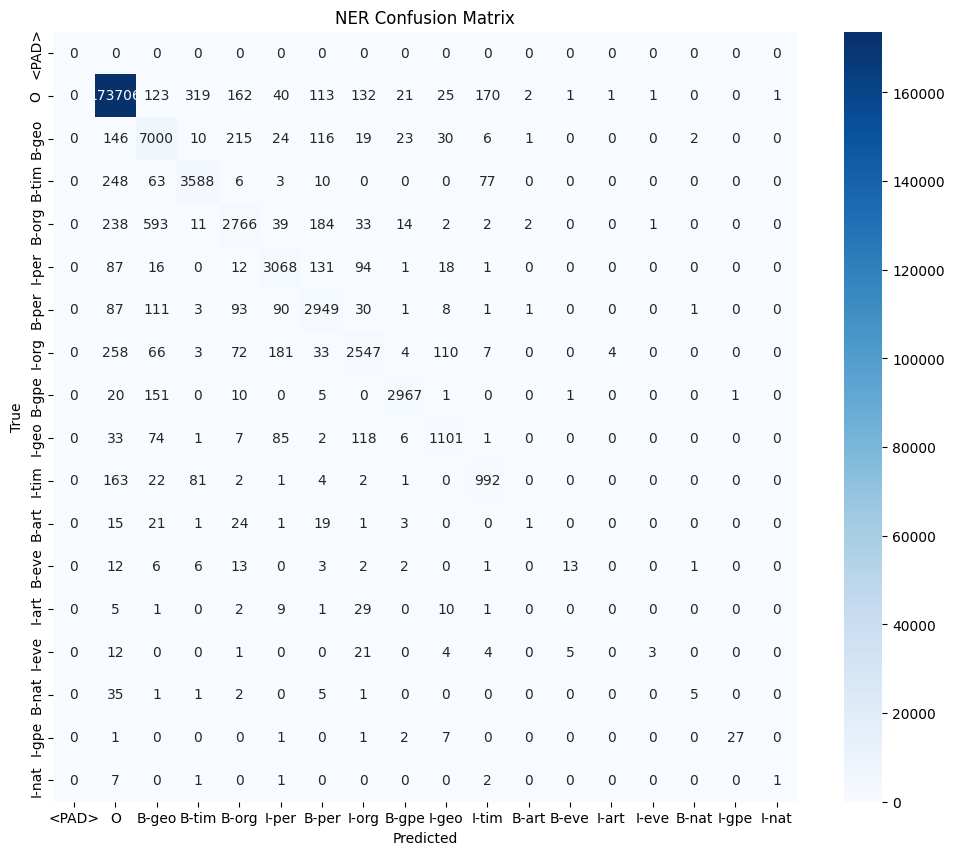

In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

flat_true = [tag for seq in true_tags for tag in seq]
flat_pred = [tag for seq in pred_tags for tag in seq]

labels = list(tag2idx.keys())

# Compute confusion matrix
cm = confusion_matrix(flat_true, flat_pred, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('NER Confusion Matrix')
plt.show()

In [20]:
# Few Example Predictions
import random

NUM_EXAMPLES = 5  # Adjustable

# Pick random samples (change to desired indices or shuffle)
indices = random.sample(range(len(true_tags)), NUM_EXAMPLES)

for idx in indices:
    word_idxs = Xw_val[idx]
    seq_len = np.count_nonzero(word_idxs != PAD_IDX)
    words = [idx2word.get(i, '<UNK>') for i in word_idxs[:seq_len]]
    print(f"Sentence [{idx}]: {' '.join(words)}")
    print(f" True tags: {' '.join(true_tags[idx])}")
    print(f" Pred tags: {' '.join(pred_tags[idx])}")
    print('-' * 80)

Sentence [906]: If home sales continued at this rate for a full year , 6.7 million homes would change hands .
 True tags: O O O O O O O O O O O O O O O O O O O
 Pred tags: O O O O O O O O O O O O O O O O O O O
--------------------------------------------------------------------------------
Sentence [2077]: In other violence , in the same province , Afghan authorities say 17 Taleban insurgents have been killed Saturday .
 True tags: O O O O O O O O O B-gpe O O O B-org O O O O B-tim O
 Pred tags: O O O O O O O O O B-gpe O O O B-org O O O O B-tim O
--------------------------------------------------------------------------------
Sentence [7303]: The National Guard is dropping hay bales from helicopters over the western U.S. state of Colorado to feed stranded cattle , while officials in surrounding states work to restore power after two powerful snowstorms hit
 True tags: O B-org I-org O O O O O O O O O B-geo O O B-geo O O O O O O O O O O O O O O O O O O O
 Pred tags: O B-org I-org O O O O 